In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#from keras.layers.merge import add
import matplotlib.pyplot as plt
import os
import scipy

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, Tensor

In [4]:
from MOFormer_modded.transformer import Transformer, TransformerRegressor
from MOFormer_modded.dataset_modded import MOF_ID_Dataset
from MOFormer_modded.tokenizer.mof_tokenizer import MOFTokenizer
import csv
import yaml
from MOFormer_modded.model.utils import *

/home/sartaaj/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
qmof_df = pd.read_csv("qmof.csv")
qmof_df

/tmp/ipykernel_358318/1200223640.py:1: DtypeWarning: Columns (40,41,43,44,45,46,47,49,50,51,52,53,55,56,57,65,66,67,68,69,77,78,79,80,81,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  qmof_df = pd.read_csv("qmof.csv")


,qmof_id,name,info.formula,info.formula_reduced,info.mofid.mofid,info.mofid.mofkey,info.mofid.smiles_nodes,info.mofid.smiles_linkers,info.mofid.smiles,info.mofid.topology,...,outputs.hse06.energy_elec,outputs.hse06.net_magmom,outputs.hse06.bandgap,outputs.hse06.cbm,outputs.hse06.vbm,outputs.hse06.directgap,outputs.hse06.bandgap_spins,outputs.hse06.cbm_spins,outputs.hse06.vbm_spins,outputs.hse06.directgap_spins
0,qmof-8a95c27,ABACUF01_FSR,Ba2CuC6H14O16,Ba2CuC6H14O16,NaN,NaN,"['O', '[Ba]', '[Cu]']",['[O-]C=O'],O.[Ba].[Cu].[O-]C=O,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,qmof-019ba28,ABALOF_FSR,Cu12C36H56I16N4S4,Cu3C9H14I4NS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,qmof-830ed1c,ABAVIJ_FSR,Co4C48H32N8O16,CoC12H8N2O4,[Co].[O-]C(=O)c1ccncc1 MOFid-v1.rtl.cat0,Co.TWBYWOBDOCUKOW.MOFkey-v1.rtl,['[Co]'],['[O-]C(=O)c1ccncc1'],[Co].[O-]C(=O)c1ccncc1,rtl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,qmof-5bd4a24,ABAVOP_FSR,Co4C48H32N8O16,CoC12H8N2O4,[Co].[O-]C(=O)c1ccncc1 MOFid-v1.rtl.cat0,Co.TWBYWOBDOCUKOW.MOFkey-v1.rtl,['[Co]'],['[O-]C(=O)c1ccncc1'],[Co].[O-]C(=O)c1ccncc1,rtl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,qmof-644aab4,ABAXUZ_FSR,Zn2C50H32N6O8S4,ZnC25H16N3O4S2,NaN,NaN,['[Zn][Zn]'],"['[O-]C(=O)c1cccc(c1)c1nccs1', 'n1ccc(cc1)c1cc...",[O-]C(=O)c1cccc(c1)c1nccs1.[Zn][Zn].n1ccc(cc1)...,NaN,...,-811.553858,0.0,2.901747,2.246703,-0.655044,True,"[None, None]","[None, None]","[None, None]","[None, None]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20370,qmof-7aebbbb,tobacco_srsb_sym_3_on_2_sym_3_mc_0_L_2,Cu12C84H60N24,CuC7H5N2,N1=C[C](C=N1)C=Cc1cc(C=CC2=C[N]N=C2)cc(c1)C=CC...,Cu.IBPUNEAULYEGJU.MOFkey-v1.srs,['[Cu]'],['N1=C[C](C=N1)C=Cc1cc(C=CC2=C[N]N=C2)cc(c1)C=...,N1=C[C](C=N1)C=Cc1cc(C=CC2=C[N]N=C2)cc(c1)C=CC...,srs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20371,qmof-9a04c15,tobacco_srsb_sym_3_on_2_sym_3_mc_0_L_6,Cu12C84H48N60,CuC7H4N5,N1=C[C](C=N1)n1nnc(c1)c1cc(cc(c1)c1nnn(c1)C1=C...,Cu.JWLDCPHWRGZUAB.MOFkey-v1.srs,['[Cu]'],['N1=C[C](C=N1)n1nnc(c1)c1cc(cc(c1)c1nnn(c1)C1...,N1=C[C](C=N1)n1nnc(c1)c1cc(cc(c1)c1nnn(c1)C1=C...,srs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20372,qmof-0dce90f,tobacco_srsb_sym_3_on_2_sym_3_mc_0__,Cu12C60H36N24,CuC5H3N2,N1=C[C](C=N1)c1cc(cc(c1)C1=CN=N[CH]1)C1=C[N]N=...,Cu.PJSMFZDMZONQKK.MOFkey-v1.srs,"['[Cu]', '[Cu][Cu]']",['N1=C[C](C=N1)c1cc(cc(c1)C1=CN=N[CH]1)C1=C[N]...,N1=C[C](C=N1)c1cc(cc(c1)C1=CN=N[CH]1)C1=C[N]N=...,srs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20373,qmof-955fe88,tobacco_srsb_sym_3_on_4_sym_3_mc_0_L_2,Cu12C112H72N24,Cu3C28H18N6,N1=C[C](C=N1)C=CC1=CC2=CC(=CC3=CC(=CC(=C1)[C]2...,Cu.WCJPEIPZJUESBA.MOFkey-v1.srs,['[Cu]'],['N1=C[C](C=N1)C=CC1=CC2=CC(=CC3=CC(=CC(=C1)[C...,N1=C[C](C=N1)C=CC1=CC2=CC(=CC3=CC(=CC(=C1)[C]2...,srs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
water_df = pd.read_excel("predictions_with_qmof_ID.xlsx")
water_df

,Paper id,DOI,qmof_ID,MOF name,Predicted Stability,Justification,Score
0,25,https://doi.org/10.1002/chem.201702405,NaN,{[Cu 3(L-F) 6(H2O)3](H2O)3}n (1a),Unstable,Further immersing the green crystals of 1a in ...,1.0
1,25,https://doi.org/10.1002/chem.201702405,qmof-88d81f2,[Cu(L-Cl) 2]n (2a),Unstable,Further immersing the green block crystals of ...,1.0
2,31,https://doi.org/10.1002/1099-0682(200111)2001:...,qmof-4a90838,"[Cu(NO3)2(2,29-bipy)(4,49-bipy)]n·2nCH3OH",Unstable,The coordination polymer 1 is purple in the so...,1.0
3,31,https://doi.org/10.1002/1099-0682(200111)2001:...,NaN,"[Ni(tren)(4,49-bipy)]n(ClO4)2n",Unstable,"It is soluble in H 2O, MeCN, MeNO 2, DMF, or D...",1.0
4,32,https://doi.org/10.1016/j.poly.2012.07.102,qmof-9b03351,"[Zn(NO 3)2(H2O)(1,3-H 4pdta)] n(1)",Stable,This gives support to 1retaining its coordinat...,1.0
...,...,...,...,...,...,...,...
1436,10468,10.1021/acs.inorgchem.9b00388,NaN,MIL-140C_0.1,Stable,"Even under boiling conditions, no change was n...",0.9
1437,10468,10.1021/acs.inorgchem.9b00388,NaN,MIL-140C_1,Stable,Knowing that MIL-140C is among the most stable...,1.0
1438,10479,10.1002/ejic.201301543,qmof-f80342c,Cu(BDC),Unstable,The gas adsorption properties appear to depend...,0.9
1439,10479,10.1002/ejic.201301543,NaN,Cu3(BTC)2,Unstable,"This is attributed to atmospheric water, which...",0.9


In [7]:
water_df = water_df.dropna(axis = 0)
water_df = water_df[water_df['Predicted Stability'] != 'Not provided']

water_df

,Paper id,DOI,qmof_ID,MOF name,Predicted Stability,Justification,Score
1,25,https://doi.org/10.1002/chem.201702405,qmof-88d81f2,[Cu(L-Cl) 2]n (2a),Unstable,Further immersing the green block crystals of ...,1.0
2,31,https://doi.org/10.1002/1099-0682(200111)2001:...,qmof-4a90838,"[Cu(NO3)2(2,29-bipy)(4,49-bipy)]n·2nCH3OH",Unstable,The coordination polymer 1 is purple in the so...,1.0
4,32,https://doi.org/10.1016/j.poly.2012.07.102,qmof-9b03351,"[Zn(NO 3)2(H2O)(1,3-H 4pdta)] n(1)",Stable,This gives support to 1retaining its coordinat...,1.0
5,55,https://doi.org/10.1002/anie.201202992,qmof-b5487b6,PCN-200-ac,Stable,Chemical stability tests show that PCN-200 is ...,1.0
6,60,https://doi.org/10.1021/acs.inorgchem.7b02034,qmof-ebaf62f,{[Ag(bfps)]NO3}n,Stable,Compound 1was isolated as colorless crystals f...,1.0
...,...,...,...,...,...,...,...
1431,10437,10.1007/s10904-017-0571-3,qmof-6bb8058,"{[Zn(L)(4,4′-bipy)·CH3CN]n (1)",Stable,"As we expect, the single crystals of 1 remain ...",1.0
1432,10438,10.1002/anie.201207808,qmof-c441e76,CaSDB,Stable,The as-synthesized compound contains not coord...,1.0
1435,10466,10.1021/acs.cgd.8b01527,qmof-23d17f0,MOF 2,Stable,The acid-base and organic solvent resistance o...,1.0
1438,10479,10.1002/ejic.201301543,qmof-f80342c,Cu(BDC),Unstable,The gas adsorption properties appear to depend...,0.9


In [8]:
id_smiles_stable = {'qmof_ID' : [],
                    'SMILES' : [],
                    'Stability' : []
                    }

for i in water_df['qmof_ID'].values:
    id_smiles_stable['qmof_ID'].append(i)

    if water_df[water_df['qmof_ID'] == i]['Predicted Stability'].values[0] == 'Unstable':
        id_smiles_stable['SMILES'].append(qmof_df[qmof_df['qmof_id'] == i]['info.mofid.smiles'].values[0])
        id_smiles_stable['Stability'].append(0)
    
    elif water_df[water_df['qmof_ID'] == i]['Predicted Stability'].values[0] == 'Stable' or water_df[water_df['qmof_ID'] == i]['Predicted Stability'].values[0] == 'Potentially Stable':
        id_smiles_stable['SMILES'].append(qmof_df[qmof_df['qmof_id'] == i]['info.mofid.smiles'].values[0])
        id_smiles_stable['Stability'].append(1)

In [9]:
data_df = pd.DataFrame(id_smiles_stable)
data_df = data_df.dropna()
data_df

,qmof_ID,SMILES,Stability
0,qmof-88d81f2,[Cu].[O-]C(=O)c1cc(Cl)cnc1,0
1,qmof-4a90838,[Cu].n1ccc(cc1)c1ccncc1,0
2,qmof-9b03351,[O-]C(=O)C[NH](CC(=O)O)CCC[NH](CC(=O)O)CC(=O)[...,1
3,qmof-b5487b6,C(Cc1ccncc1)Cc1ccncc1.[Cu].[O-]C(=O)C1=NN=N[N]1,1
4,qmof-ebaf62f,O=C(Nc1cncc(c1)F)CCC(=O)Nc1cncc(c1)F.[Ag],1
...,...,...,...
795,qmof-6bb8058,Nc1cc(cc(c1)C(=O)[O-])C(=O)[O-].[Zn].n1ccc(cc1...,1
796,qmof-c441e76,[Ca].[O-]C(=O)c1ccc(cc1)S(=O)(=O)c1ccc(cc1)C(=...,1
797,qmof-23d17f0,N1=NN2N3[C]1c1ccc(-c4cc5-c6ccc(-c7nn([Cu]2N2N8...,1
798,qmof-f80342c,[Cu][Cu].[O-]C(=O)c1ccc(cc1)C(=O)[O-],0


(array([204.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 525.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

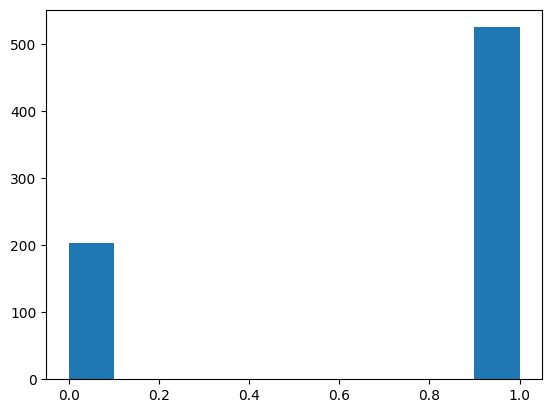

In [10]:
plt.hist(data_df['Stability'].values) #shows imbalance

In [11]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels


    def __len__(self):
        return len(self.features)


    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [12]:
tokenizer = MOFTokenizer("MOFormer_modded/tokenizer/vocab_full.txt")
config = yaml.load(open("MOFormer_modded/config_ft_transformer.yaml", "r"), Loader=yaml.FullLoader)
config['dataloader']['randomSeed'] = 0

In [13]:
print(config)

{'batch_size': 64, 'epochs': 200, 'eval_every_n_epochs': 1, 'fine_tune_from': './training_results/pretraining', 'trained_with': 'CGCNN', 'log_every_n_steps': 1, 'gpu': 'cuda:0', 'vocab_path': 'MOFormer_modded/tokenizer/vocab_full.txt', 'cuda': True, 'num_workers': 0, 'task': 'classification', 'optim': {'optimizer': 'Adam', 'init_lr': 5e-05, 'weight_decay': '1e-6'}, 'dataloader': {'valid_ratio': 0.15, 'test_ratio': 0.15, 'use_ratio': 1, 'randomSeed': 0}, 'dataset': {'data_name': 'QMOF', 'dataPath': './MOFormer_modded/dataset/core_ch4uptake_highP.csv'}, 'Transformer': {'ntoken': 4021, 'd_model': 512, 'nhead': 8, 'd_hid': 512, 'nlayers': 6, 'dropout': 0.1}}


In [14]:
def split_data(data, test_ratio, use_ratio=1, randomSeed = None):
    total_size = len(data)
    train_ratio = 1 - test_ratio
    indices = list(range(total_size))
    print("The random seed is: ", randomSeed)
    np.random.seed(randomSeed)
    np.random.shuffle(indices)
    train_size = int(train_ratio * total_size)
    test_size = int(test_ratio * total_size)
    print('Total size: {}, Train size: {}, Test size: {}'.format(total_size,
    train_size, test_size
    ))

    train_idx, test_idx = indices[:train_size], indices[-test_size-1:]



    return data[train_idx], data[test_idx]

In [15]:
data = data_df.to_numpy()

train_data, test_data = split_data(
    data, test_ratio = 0.10, 
    randomSeed= config['dataloader']['randomSeed']
)


The random seed is:  0
Total size: 729, Train size: 656, Test size: 72


In [16]:
train_data

array([['qmof-20b1e21', '[Ag].[O-]C(=O)C(NC(=O)C)Cc1c[nH]cn1', 1],
       ['qmof-a8bee64',
        'C[C]1N=NC(=C1C1=C(C)N=N[C]1C)C.C[C]1N=NC(=C1[C]1C(=NN=C1C)C)C.[Zn]',
        0],
       ['qmof-8fef316',
        '[O-]C(=O)c1nc(C(=O)[O-])c(cc1C(=O)[O-])C(=O)[O-].[OH2][Cd].[OH2][Cd][OH2]',
        0],
       ...,
       ['qmof-548e234',
        'N#C[N]C#N.[Ag].c1ccc(cn1)N(CP(c1ccccc1)c1ccccc1)CP(c1ccccc1)c1ccccc1',
        1],
       ['qmof-7494173', 'C[C]1N=NC(=C1CC1=C(C)N=N[C]1C)C.[Cd]', 1],
       ['qmof-508b13f',
        'C(Cc1ccncc1)Cc1ccncc1.Cc1cc(cc(c1)C(=O)[O-])C(=O)[O-].[Co]', 1]],
      dtype=object)

In [17]:
len(train_data) + len(test_data)

729

In [18]:
train_dataset = MOF_ID_Dataset(data = train_data, tokenizer = tokenizer)
test_dataset = MOF_ID_Dataset(data = test_data, tokenizer = tokenizer)

In [21]:
batch_size = 16

train_loader = DataLoader(
                        train_dataset, batch_size=batch_size, drop_last=True
                    )

test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True
                    )

In [22]:
from MOFormer_modded.transformer import PositionalEncoding
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class Transformer(nn.Module):
    """
    Returns representation for SMILES strings
    """
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.token_encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model

        self.init_weights()

    def init_weights(self) -> None:
        nn.init.xavier_normal_(self.token_encoder.weight)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.token_encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, 0:1, :] #this was added in by me

        return output.squeeze(dim = 1) #this was added in by me
        #return output

In [31]:
class ClassificationTransformer(nn.Module):
    def __init__(self, transformer, input_dim = 512, hidden_dim = 256, output_dim = 1):
        super(ClassificationTransformer, self).__init__()
        self.transformer = transformer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.transformer(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)

        return x


In [46]:
transformer_SMILES = Transformer(**config['Transformer'])
model = ClassificationTransformer(transformer = transformer_SMILES)

In [47]:
if torch.cuda.is_available() and config['gpu'] != 'cpu':
    device = config['gpu']
    torch.cuda.set_device(device)
    config['cuda'] = True

else:
    device = 'cpu'
    config['cuda'] = False
print("Running on:", device)

Running on: cuda:0


In [36]:
for c, (X1, y) in enumerate(train_loader):
    print(transformer_SMILES(X1).shape)
    print(model(X1).shape)
    break

torch.Size([16, 512])
torch.Size([16, 1])


In [48]:
criterion = nn.BCEWithLogitsLoss()

In [49]:
layer_list = []
for name, param in model.named_parameters():
    if 'fc_out' in name:
        print(name, 'new layer')
        layer_list.append(name)
params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in layer_list, model.named_parameters()))))
base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in layer_list, model.named_parameters()))))

if config['optim']['optimizer'] == 'SGD':
    optimizer = optim.SGD(
        [{'params': base_params, 'lr': config['optim']['lr']*0.2}, {'params': params}],
            config['optim']['init_lr'], momentum=config['optim']['momentum'], 
        weight_decay=eval(config['optim']['weight_decay'])
    )
elif config['optim']['optimizer'] == 'Adam':
    optimizer = optim.Adam(
        [{'params': base_params, 'lr': config['optim']['init_lr']*1}, {'params': params}],
        config['optim']['init_lr']*200, weight_decay=eval(config['optim']['weight_decay'])
    )
else:
    raise NameError('Only SGD or Adam is allowed as optimizer')  

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [51]:
n_iter = 0
valid_n_iter = 0
best_valid_loss = np.inf
best_valid_mae = np.inf
best_valid_roc_auc = 0

loss_history, val_history, auc_val_history = [], [], []
model.train()
num_epoch = 20

for epoch_counter in range(num_epoch):
    loss_temp = []
    for bn, (input1, target) in enumerate(train_loader):
        if config['cuda']:
            input_var_1 = input1.to(device)
        else:
            input_var_1 = input1.to(device)
        
        if config['cuda']:
            #target_var = Variable(target_normed.to(device, non_blocking=True)) #experimenting with normalization vs non-norm
            target_var = Variable(target.to(device, non_blocking=True))
        else:
            #target_var = Variable(target_normed)
            target_var = Variable(target)
        
        if config['cuda']:
            model = model.to(device)

        target_var = target_var.reshape(-1, 1)

        # compute output
        output = model(input_var_1)
        output = output.reshape(-1, 1)

        loss = criterion(output, target_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_iter += 1

        loss_temp.append(loss.item())
    
    loss_history.append(np.mean(loss_temp))

    val_temp = []
    auc_val_temp = []
    model.eval()
    with torch.no_grad():
        for bn, (input1, target) in enumerate(test_loader):
            if config['cuda']:
                input_var_1 = input1.to(device)
            else:
                input_var_1 = input1.to(device)
            
            if config['cuda']:
                #target_var = Variable(target_normed.to(device, non_blocking=True))
                target_var = Variable(target.to(device, non_blocking=True))
            else:
                #target_var = Variable(target_normed)
                target_var = Variable(target)

            target_var = target_var.reshape(-1, 1)
            # compute output
            output = model(input_var_1)
            output = output.reshape(-1, 1)

            loss_val = criterion(output, target_var)
            val_temp.append(loss_val.item())
            auc_val_temp.append(roc_auc_score(target_var.cpu().numpy(), output.cpu().numpy()))
    
    auc_val_history.append(np.mean(auc_val_temp))

    
    val_history.append(np.mean(val_temp))

    if epoch_counter % config['log_every_n_steps'] == 0:
        print(f'Epoch: {epoch_counter+1}, Batch: {bn}, Loss: {loss_history[-1]}, Test Loss: {val_history[-1]}, AUC test = {auc_val_history[-1]}')
    
    
    

Epoch: 1, Batch: 3, Loss: 0.5876824535974642, Val Loss: 0.7120351940393448, SRCC_test = 0.45960012210012213
Epoch: 2, Batch: 3, Loss: 0.5818616042776805, Val Loss: 0.7144465744495392, SRCC_test = 0.46428571428571425
Epoch: 3, Batch: 3, Loss: 0.5816657201545995, Val Loss: 0.7148406058549881, SRCC_test = 0.4699786324786325
Epoch: 4, Batch: 3, Loss: 0.5816075431137551, Val Loss: 0.7145193815231323, SRCC_test = 0.4843253968253969
Epoch: 5, Batch: 3, Loss: 0.5816131881097468, Val Loss: 0.7138087153434753, SRCC_test = 0.4901404151404151
Epoch: 6, Batch: 3, Loss: 0.5814922582812425, Val Loss: 0.712522342801094, SRCC_test = 0.4771214896214896
Epoch: 7, Batch: 3, Loss: 0.5814647725442561, Val Loss: 0.7112004160881042, SRCC_test = 0.4826159951159951
Epoch: 8, Batch: 3, Loss: 0.5813120967004357, Val Loss: 0.7105667293071747, SRCC_test = 0.5096611721611721
Epoch: 9, Batch: 3, Loss: 0.5811728326285758, Val Loss: 0.7068728059530258, SRCC_test = 0.4967643467643468
Epoch: 10, Batch: 3, Loss: 0.5795590

Text(0.5, 1.0, 'Learning curve')

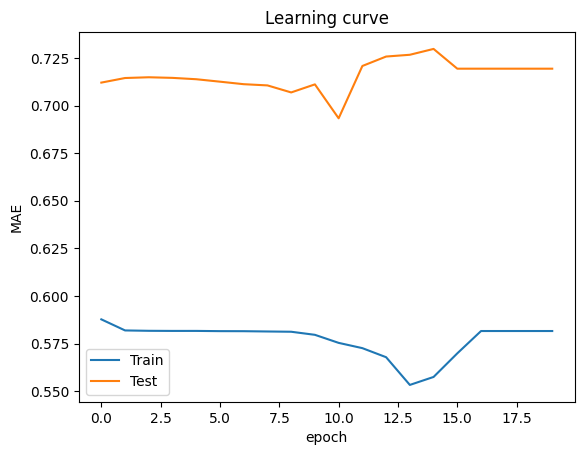

In [52]:
plt.plot(loss_history)
plt.plot(val_history)
plt.legend(['Train', 'Test'])
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Learning curve')

In [342]:
#test set
model.eval()
predictions_test = []
actual_test = []

for bn, (input1, input2, target) in enumerate(test_loader):
    if config['cuda']:
        input_var_1 = input1.to(device)
        input_var_2 = input2.to(device)
    else:
        input_var_1 = input1.to(device)
        input_var_2 = input2.to(device)
    
    target_normed = normalizer.norm(target)
    
    if config['cuda']:
        #target_var = Variable(target_normed.to(device, non_blocking=True))
        target_var = Variable(target.to(device, non_blocking=True))
    else:
        #target_var = Variable(target_normed)
        target_var = Variable(target)

    # compute output
    output = model(input_var_2, input_var_1)
    
    for i, j in zip(output.cpu().detach().numpy().flatten(), target_var.cpu().detach().numpy().flatten()):
        predictions_test.append(i)
        actual_test.append(j)

In [343]:
#train set
model.eval()
predictions_train = []
actual_train = []

for bn, (input1, input2, target) in enumerate(train_loader):
    if config['cuda']:
        input_var_1 = input1.to(device)
        input_var_2 = input2.to(device)
    else:
        input_var_1 = input1.to(device)
        input_var_2 = input2.to(device)
    
    target_normed = normalizer.norm(target)
    
    if config['cuda']:
        #target_var = Variable(target_normed.to(device, non_blocking=True))
        target_var = Variable(target.to(device, non_blocking=True))
    else:
        #target_var = Variable(target_normed)
        target_var = Variable(target)

    # compute output
    output = model(input_var_2, input_var_1)
    
    for i, j in zip(output.cpu().detach().numpy().flatten(), target_var.cpu().detach().numpy().flatten()):
        predictions_train.append(i)
        actual_train.append(j)

In [344]:
criterion = nn.L1Loss()

In [345]:
criterion(torch.tensor(predictions_train, dtype = torch.float), torch.tensor(actual_train, dtype = torch.float)).item()

0.739402711391449

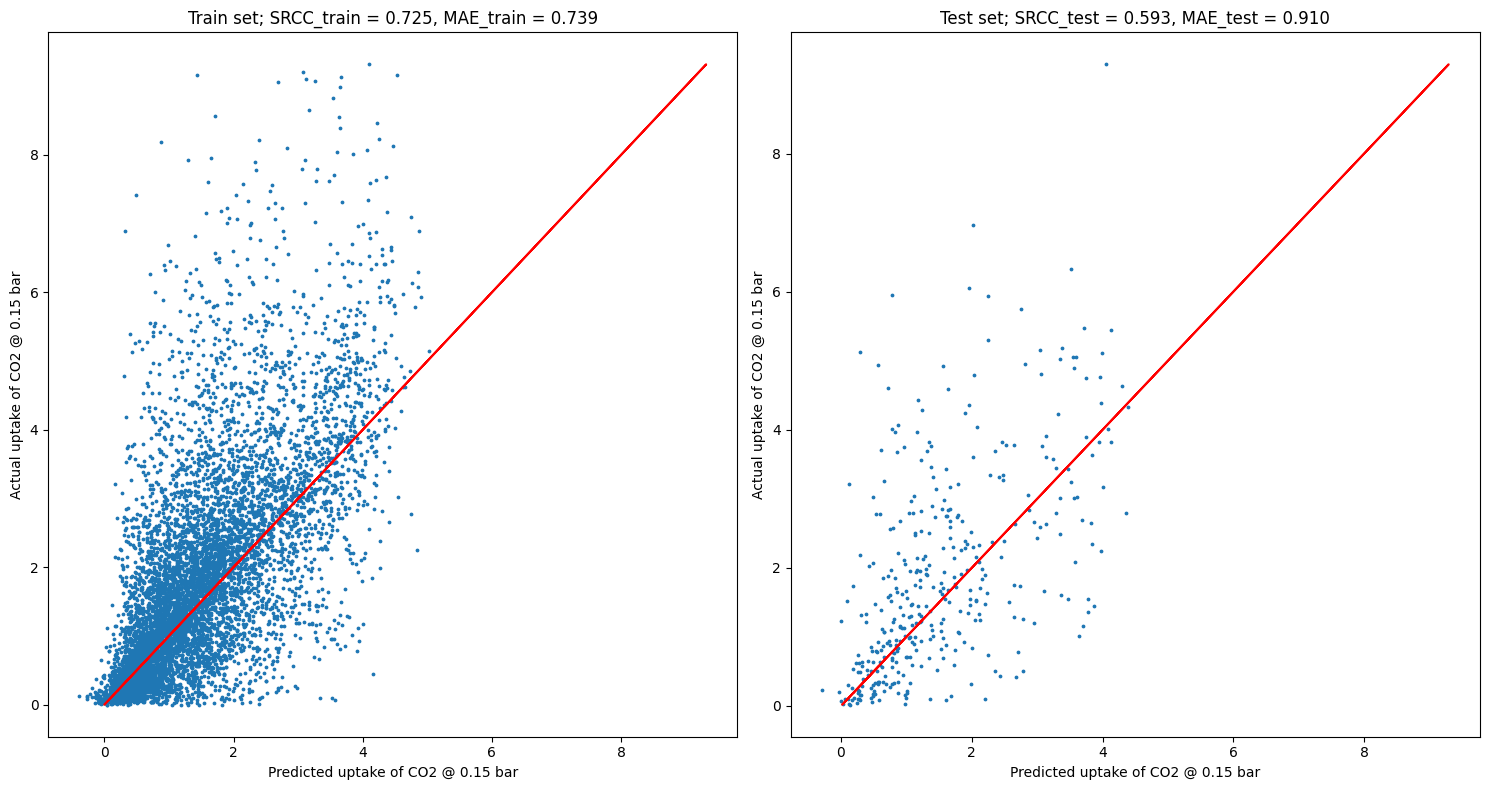

In [346]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8))

ax1.scatter(predictions_train, actual_train, s = 3)
ax1.plot(actual_train, actual_train, color = 'red')
ax1.set_xlabel('Predicted uptake of CO2 @ 0.15 bar')
ax1.set_ylabel('Actual uptake of CO2 @ 0.15 bar')
ax1.set_title('Train set; SRCC_train = {:.3f}, MAE_train = {:.3f}'.format(scipy.stats.spearmanr(predictions_train, actual_train)[0], criterion(torch.tensor(predictions_train, dtype = torch.float), torch.tensor(actual_train, dtype = torch.float)).item()))

ax2.scatter(predictions_test, actual_test, s = 3)
ax2.plot(actual_test, actual_test, color = 'red')
ax2.set_xlabel('Predicted uptake of CO2 @ 0.15 bar')
ax2.set_ylabel('Actual uptake of CO2 @ 0.15 bar')
ax2.set_title('Test set; SRCC_test = {:.3f}, MAE_test = {:.3f}'.format(scipy.stats.spearmanr(predictions_test, actual_test)[0], criterion(torch.tensor(predictions_test, dtype = torch.float), torch.tensor(actual_test, dtype = torch.float)).item()))

plt.tight_layout()
plt.savefig("CoRE_2019/figures/parity_plot_CO2_uptake_0_15bar.png")

plt.show()